### AST 5731 
#### Group 1 - Project 1
#### Group Members: 

*Style Notes (delete this cell prior to submission):
I figured we can use '###' for sections in markdown, then '####' if we want subsections (in which case we would probably do x.y formatting for the subsections). It might be tidier if we have markdown cells then code in each section, but we could also alternate between the two if people think that would be better*

*also, leaving markdown comments in italics so we make sure to delete them before submission*

 ##### Contents
 1.   [Introduction](#introduction)
 2.   [Data](#data)  
    2.1 [Importing Data](#importing-data)    
   2.2 [Data Processing](#processing)  
   2.3 [Data Visualization](#visualization)
 3.   [Analysis](#analysis)   
    3.1 [Components of Statistical Model](#model)  
    3.2 [Sensitivity Analysis](#senstivity)
 4.   [Results](#results)
 5.   [Discussion](#discussion)

### 1. Introduction 
<a id='introduction'></a>

In this analysis, we are interested in determining the size of exoplanet TOI-564 b. To do this, we will estimate the mean of the exoplanet's transit, as this *[explain how to get the size of an exoplanet given its transit, maybe with the equation we will use in the end?]*. The answer to this question could also hint at whether TOI-564 b has a stable orbit, or if there is another planet in the system causing timing variations.

Thus our statistical question is as follows:

What is the mean of the distribution of the depth of exoplanet TOI-564 b's transit?

The overall question we are trying to answer: What is the radius of exoplanet TOI-564b? 

This exoplanet was detected using the transit method, meaning that the planet was observed passing in front of it's star, causing a small decrease in the brightness of the star. This is represented by a dip in the light curve. 

The dip, or transit depth, is related to the radius of the exoplanet by the following equation:
$$\displaystyle \Delta F_{rel} = \frac{R_p}{R_s}$$
where $\Delta F_{rel}$ is the relative change in flux of the light curve, $R_p$ is the radius of the planet, and $R_s$ is the radius of the star. For TOI-564b, $R_s=1.04(\pm 0.05)R_{sun}$

TOI-564b was observed by TESS in multiple sectors, but our analysis is focused on Sector 34 data. With an observation time of approximately 28 days and a orbital period of 1.65 days, we were able to extract 14 transit depths. 

The multiple measurements of the transit depth should create a normal distribution. We will preform a Bayesian analysis to find the mean transit depth and use that to find the radius of exoplanet TOI-564b.

### 2. Data
<a id='data'></a>

*Description of the data and how it was obtained (talk about TESS briefly I guess)*

Note: Our project was run on python 3.9.13, and an environment package detailing the versions for all packages used can be found [here](https://github.com/tylerbarna/AST5731-Group1/blob/main/environment.yml).

Importing packages used for project:

In [1]:
import csv
import dis
import inspect
import os
import sys
import time


import astropy
import astroquery
# import eleanor ## alternative for TESS data analysis
import lightkurve as lk ## for importing and manipulating TESS data
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy import constants as const
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from lightkurve import search_targetpixelfile

from numpy import interp

from sklearn import preprocessing as pp

from scipy import linalg as la
from scipy import optimize
from scipy import integrate

from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import binom

from IPython.display import display_html
from IPython.display import Image

%matplotlib inline

## set seed for reproducibility
random.seed(5731)

#### 2.1 Importing Data
<a id='importing'></a>  

While it is possible to search for and import data directly from an online database using the lightkurve package, we found this unprocessed data to be more difficult to work with, as the lighkurve method does not filter data particularly well. Instead, we opted to use data from MAST, which was processed by the TESS Science Office to reduce outliers caused by instrumental effects and the orbit of TESS. 

In [2]:
## read in data using astropy.io.fits 
fits_file = fits.open('./data/lc.fits')
fits_file.info()
print()

## read in the light curve data as a pandas dataframe
df = pd.DataFrame(fits_file[1].data)
df.info()


Filename: ./data/lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18231R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18231 entries, 0 to 18230
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TIME             17457 non-null  float64
 1   TIMECORR         18231 non-null  float32
 2   CADENCENO        18231 non-null  int32  
 3   SAP_FLUX         17411 non-null  float32
 4   SAP_FLUX_ERR     17411 non-null  float32
 5   SAP_BKG          17411 non-null  float32
 6   SAP_BKG_ERR      17411 non-null  float32
 7   PDCSAP_FLUX      16855 non-null  float32
 8   PDCSAP_FLUX_ERR  16855 non-null  float32
 9   QUALITY          18231 non-null  int32  
 10  PSF_CENTR1  

Now, let's plot the light curve!

In [3]:
popOutlier = True
if popOutlier:
    df = df[(df['PDCSAP_FLUX'] <= 8590) | (np.isnan(df['PDCSAP_FLUX']))]

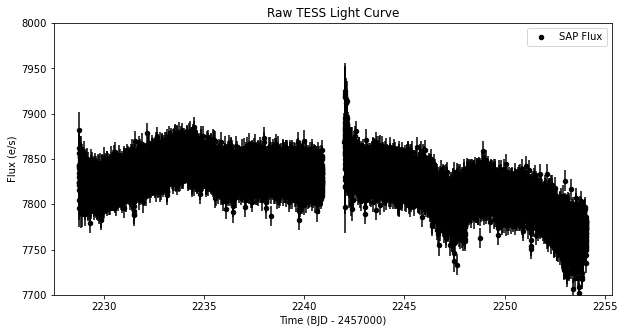

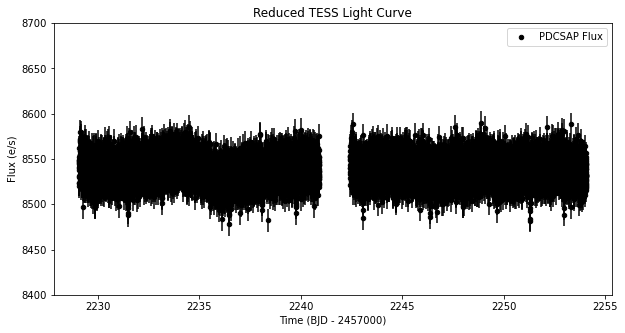

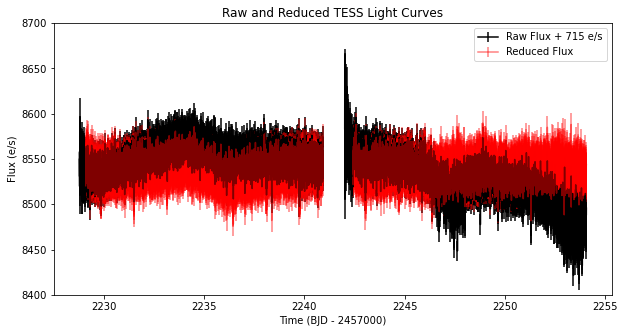

In [4]:
## plot raw flux data (sap_flux)
df.plot(x='TIME', y='SAP_FLUX', yerr='SAP_FLUX_ERR', figsize=(10,5), color='black', label='SAP Flux', kind='scatter', title='Raw TESS Light Curve')
plt.ylim(7700, 8000)
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Flux (e/s)');
plt.show();

## plot the reduced data (pdcsap_flux)
df.plot(x='TIME', y='PDCSAP_FLUX', yerr='PDCSAP_FLUX_ERR', figsize=(10,5), color='black', label='PDCSAP Flux', kind='scatter', title='Reduced TESS Light Curve')
plt.ylim(8400, 8700)
#plt.ylim(0.9*df['SAP_FLUX'].min(), 1.1*df['SAP_FLUX'].max()) ## for consistency of comparison
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Flux (e/s)');
plt.show();

## plot them together, adusting values so they are centered together
raw_mean = df['SAP_FLUX'].mean()
reduced_mean = df['PDCSAP_FLUX'].mean()
mean_diff = reduced_mean - raw_mean
raw_flux_adj = df['SAP_FLUX'] + mean_diff
reduced_flux_adj = df['PDCSAP_FLUX']
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(df['TIME'], raw_flux_adj, yerr = df['SAP_FLUX_ERR'],color='black', label='Raw Flux + {} e/s'.format(round(mean_diff)))
ax.errorbar(df['TIME'], reduced_flux_adj, yerr=df['PDCSAP_FLUX_ERR'], color='red', label='Reduced Flux',alpha=0.5)
plt.ylim(8400, 8700)
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Flux (e/s)');
plt.title('Raw and Reduced TESS Light Curves')
plt.legend();
plt.show();

The "SAP_FLUX" column represents the unreduced lightcurve data, whereas the the "PDCSAP_FLUX" column represents the reduced lightcurve data. We note that the reduced data has an average flux value of roughly 715 $e/s$ higher than the raw lightcurve. One can clearly see that this has significantly fewer outliers. This makes it easier to detect actual transits and the mean flux value will be more representative of the actual baseline. As a result, we will be using the reduced data for our analysis.

2.2 Data Processing 
<a id='processing'></a>  

To make analysis easier, we will be normalizing the data. This will be accomplished by using the equation
$$
\begin{equation}
norm(x) = \frac{x}{x_{median}}
\end{equation}
$$
where $x_{median}$ is the median flux value, and $norm(x)$ is the resulting normalized flux value. For the flux error, we determine the scale ratio for each flux point and then apply that same scaling to the corresponding error value. This ensures that the error values are scaled in the same way as the flux values.

Max Flux: 8589.6435546875 e/s
Mean Flux: 8537.891713855019 e/s
Min Flux: 8478.0234375 e/s

Normalized Flux Max: 1.0060480383121537
Normalized Flux Mean: 0.999986688080671
Normalized Flux Min: 0.9929747135324106


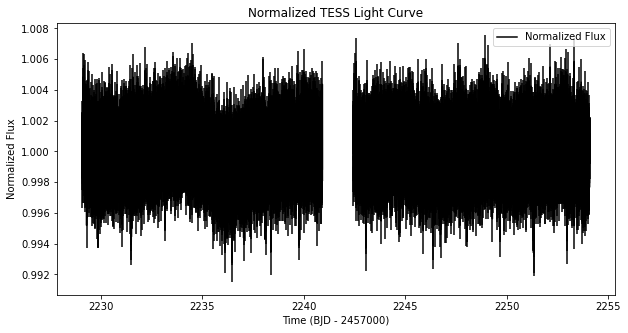

In [5]:
## retreive the flux data and flux error as numpy arrays to process

flux = df['PDCSAP_FLUX'].astype(float)
flux_err = df['PDCSAP_FLUX_ERR'].astype(float)

## find the max and min flux values
max_flux = np.max(flux)
min_flux = np.min(flux)
median_flux = np.nanmedian(flux)
mean_flux = np.mean(flux)


print('Max Flux: %s e/s'% max_flux)
print('Mean Flux: %s e/s'% np.nanmean(flux))
print('Min Flux: %s e/s'% min_flux)

## define normalization function
norm_factor = lambda x: np.nanmedian(x) ## modify this to change the method for normalization
# norm_x = lambda x: (x - np.min(x))/(norm_factor(x) - np.min(x))
norm_x = lambda x: (x)/(norm_factor(x))
norm_flux = norm_x(flux)
#norm_flux_err = norm(flux_err)

## normalize flux error by taking the ratio of the normalized flux to the original flux for each data point
norm_ratio = norm_flux/flux ## will be less than 1
norm_flux_err = norm_ratio*flux_err ## will be less than flux_err


## add normalized flux and flux error to the dataframe
df['NORM_FLUX'] = norm_flux
df['NORM_FLUX_ERR'] = norm_flux_err
norm_flux_mean = df['NORM_FLUX'].mean()

print()
print('Normalized Flux Max: %s'% np.max(norm_flux))
print('Normalized Flux Mean: %s'% norm_flux_mean)
print('Normalized Flux Min: %s'% np.min(norm_flux))


## plot the normalized flux data
df.plot(x='TIME', y='NORM_FLUX', yerr='NORM_FLUX_ERR', figsize=(10,5), color='black', label='Normalized Flux', title='Normalized TESS Light Curve',alpha=1)
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Normalized Flux');  
plt.show();

In order to find the transit depth of the 14 transits in the dataset, the transits are separated into individual light curves by manually identifying their rough start and end times. Then, the depth and exact time of the transit are calculated based on the minimum flux, and displayed on their respective plots.

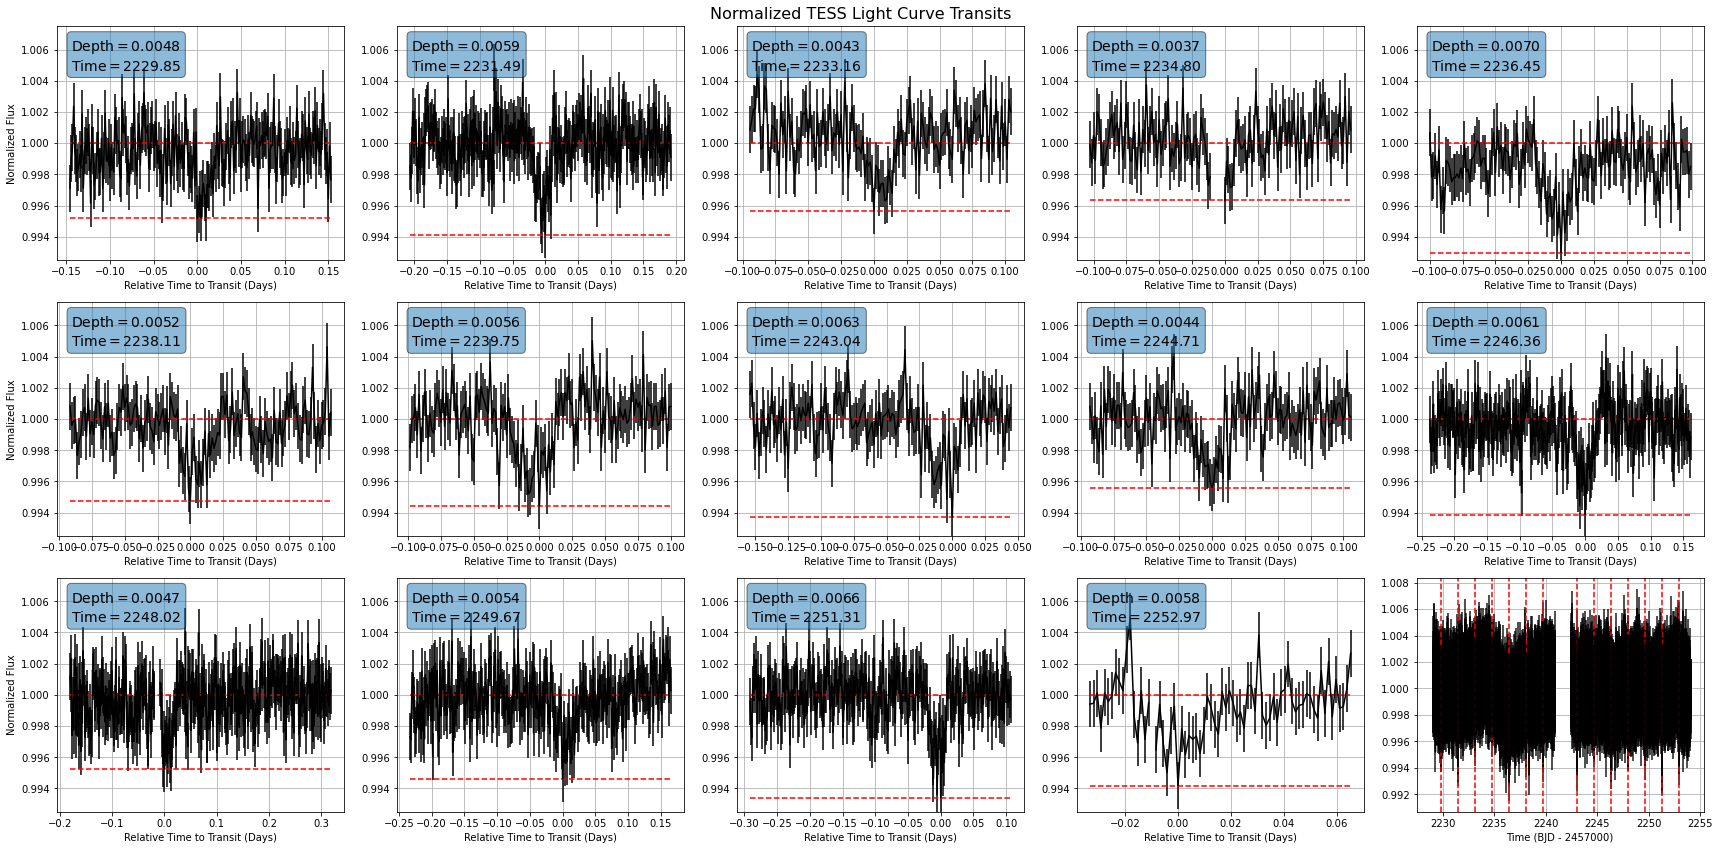

Transit Depths stored in data frame 'tdf':


,Transit,Time,Depth
0,t01,2229.853950,0.004800
1,t02,2231.492896,0.005853
2,t03,2233.155448,0.004335
3,t04,2234.797162,0.003657
4,t05,2236.449981,0.007012
5,t06,2238.106961,0.005218
6,t07,2239.750045,0.005566
7,t08,2243.044534,0.006277
8,t09,2244.705672,0.004391
9,t10,2246.361248,0.006118


In [6]:
## define function to seperate data into transits and plot them in subplots
transit_times = {
    't01': [2229.7, 2230],
    't02': [2231.3, 2231.7],
    't03': [2233.05, 2233.25],
    't04': [2234.7, 2234.9],
    't05': [2236.35, 2236.55],
    't06': [2238, 2238.2],
    't07': [2239.65, 2239.85],
    't08': [2243, 2243.2],
    't09': [2244.6, 2244.8],
    't10': [2246.2, 2246.6],
    't11': [2247.7, 2248.2],
    't12': [2249.5, 2249.9],
    't13': [2251.2, 2251.6],
    't14': [2252.9, 2253],
}

def transits(df, times, plot=True, save=False):
    '''
    Creates a dataframe of the time and depth of each transit and also plots them
    '''

    fig, axs = plt.subplots(3,5, figsize=(24, 12)) 
    fig.set_facecolor('white') 
    idx=0 ##counter for subplot index
    depths = {} ## dictionary to store transit depths
    times = {} ## dictionary to store the width of each transit
    for key, value in transit_times.items():
        
        transit = df[(df['TIME'] > value[0]) & (df['TIME'] < value[1])]
        min_flux = np.min(transit['NORM_FLUX'])
        depths[key] = norm_flux_mean - min_flux
        #times[key] = interp(min_flux, transit['NORM_FLUX'], transit['TIME'])
        times[key] = transit['TIME'][transit['NORM_FLUX'].idxmin()]

        if plot:
            ax = axs.flatten()[idx]
            relative_time = times[key] - transit['TIME']
            ax.errorbar(relative_time, transit['NORM_FLUX'], yerr=transit['NORM_FLUX_ERR'], color='black', label=key)
            #transit.plot(x=relative_time, y='NORM_FLUX', yerr='NORM_FLUX_ERR', ax=ax, color='black', label=key)
            ax.hlines(norm_flux_mean, relative_time.min(), relative_time.max(), color='r', linestyle='--', label='Mean Flux')
            ax.hlines(min_flux, relative_time.min(), relative_time.max(), color='r', linestyle='--', label='Transit Depth')
            ax.set_ylim(0.9925, 1.0075)
            ax.set_xlabel('Relative Time to Transit (Days)')
            ax.grid()

            textstr = '\n'.join((
                r'$\mathrm{Depth}=%.4f$' % (depths[key], ),
                r'$\mathrm{Time}=%.2f$' % (times[key], )))
            props = dict(boxstyle='round', alpha=0.5)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
            
        idx+=1
    ## hide the empty subplot
    #axs.flatten()[14].set_visible(False)

    
    ## Alternate option: on the 14th subplot, plot the entire light curve with axv lines for each transit
    if plot:
        ax = axs.flatten()[14]
        ax.errorbar(df['TIME'], df['NORM_FLUX'], yerr=df['NORM_FLUX_ERR'], color='black', label='Normalized Flux',alpha=0.9)
        ax.set_xlabel('Time (BJD - 2457000)')
        ax.grid()
        #ax.hlines(norm_flux_mean, df['TIME'].min(), df['TIME'].max(), color='r', linestyle='--', label='Mean Flux')
        [ax.axvline(x=times[key], color='r', linestyle='--') for key in times.keys()]   
        for idx in (0,5,10):
            ax = axs.flatten()[idx]
            ax.set_ylabel('Normalized Flux')
        
        fig.suptitle('Normalized TESS Light Curve Transits', fontsize=16)
        plt.tight_layout()
        fig.save('transits.png') if save else None
        plt.show();
    ## combine dictionaries into one before converting into a dataframe
    tDict = {'Transit': list(times.keys()), 'Time': list(times.values()),'Depth': list(depths.values())}
    tdf = pd.DataFrame.from_dict(tDict)

    return tdf

tdf = transits(df=df, times=transit_times, plot=True, save=False)


print("Transit Depths stored in data frame 'tdf':")
display(tdf)

#### 2.3 Data Visualization
<a id='visualization'></a>

Now that we have found our transit depths, we can visualize the data we will be working with.

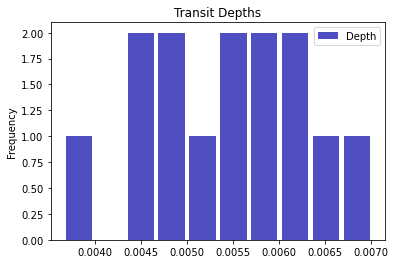

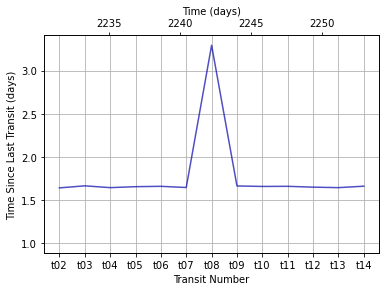

In [7]:
# plot transit depths: histogram
depths_scatter = tdf.plot(y = 'Depth',
                          color = '#0504aa',
                          alpha = 0.7,
                          rwidth = 0.85,
                          title = 'Transit Depths',
                          kind = 'hist')
plt.show();


## plot time between transits
times = tdf['Time'].values
time_diff = np.diff(times)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny() ## this is just so we can have a second x-axis, will be populated with a dummy plot
time_diff_scatter = ax1.plot(tdf['Transit'][1:], time_diff, color = '#0504aa', alpha = 0.7)
ax2.plot(tdf['Time'][1:],np.ones(len(tdf['Time'][1:])), color = 'white', alpha = 0.0)

ax1.set_xlabel('Transit Number')
ax1.set_ylabel('Time Since Last Transit (days)')
ax2.set_xlabel('Time (days)')
ax1.grid()
plt.show();



Note that, while the time between transit 7 and transit 8 seems to be roughly double the other values, this occurs at the time in TESS' orbit when it is unable to provide data, suggesting that there is a transit that occured during this gap given how consistent the time between transits is otherwise.

### 3. Bayesian Analysis
<a id='analysis'></a>

*describe the model and what decisions we made in markdown, then do the analysis in python code cells*

Recall our statistical question: What is the mean of the distribution of the depth of exoplanet TOI-564 b's transit?

To answer this, we will perform a Bayesian analysis on our data.
 

#### 3.1 Components of Statistical Model
<a id='model'></a>

*area where we list the components of the model (eg parameter, parameter space, data characteristics). what we discussed in our meeting on 09/30*

Both our prior and posterior distributions will be normal distributions. The prior distribution will be centered at the mean of the transit depths, and the posterior distribution will be centered at the mean of the prior distribution. In the next section, we will perform sensitivity analysis to check our prior distribution.

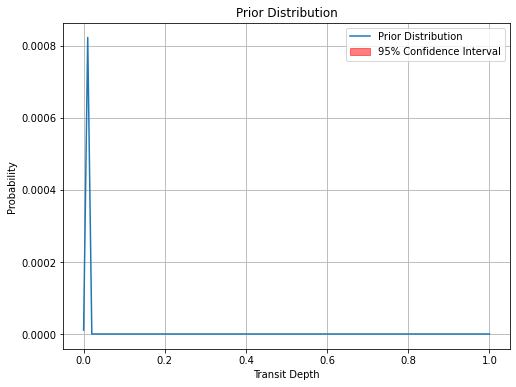

In [8]:
## define function to calculate prior distribution assuming it is centered at the mean of the transit depth and plot it
def prior_dist(df,params=False, plot=True, save=False):
    '''
    Calculates the prior distribution of the transit depth
    '''
    mean = np.mean(df['Depth'])
    std = np.std(df['Depth'])
    if params: ## so params can be manually provided
        mean = params['mean']
        std = params['std']
    x = np.linspace(0, 1, 100)
    y = norm.pdf(x, mean, std)
    dict = {'x': x, 'y': y, 'mean': mean, 'std': std}
    if plot:
        ## calculate 95% confidence interval
        ci = norm.interval(0.95, mean, std)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(x,y,label='Prior Distribution')
        ax.fill_between(x, y, where=(x>ci[0]) & (x<ci[1]), color='r', alpha=0.5,label='95% Confidence Interval')
        plt.title('Prior Distribution')
        ax.set_xlabel('Transit Depth')
        ax.set_ylabel('Probability')
        plt.grid()
        plt.legend()
        plt.savefig('prior_dist.png') if save else None

        plt.show()
    return dict

priorDict = prior_dist(tdf, plot=True, save=False);

Alex's Analysis:

Components of the statistical model:
  - Parameters: $\theta$ is the mean transit depth that we are trying to find in order to determine the radius of TOI-564b
  - Parameter Space: $\Theta$ is any real number between 0 and 1. Because we normalized the data, the transit depths cannot be larger then 1 or less then 0
  - Data Characteristics: $x_i$ is the $i^{th}$ transit depth from the data where $i=1,2,...,n$ and $n=14$
  - Sample Space: the sample space is the same as the parameter space in this case, all real values between 0 and 1
  - Likelihood: From the transit depth measurements, we are assuming it to be $\sim N(\theta,v)$, where $v$ is the variance. We get the variance from squaring the mean of the measurement errors, as we are assuming they represent one standard deviation
  - Prior: We are assuming a normal distribution
  $$\displaystyle \nu(\mu) \sim \text{Normal}(a,b)$$
  For a and b, we are chosing a standard prior with a=0 and b=1 to start
  - Posterior: With these assumptions of a normal prior and normal likelihood, we are able to say the posterior will be a normal distribution as well with the parameters
  $$ \theta_p = (\frac{n}{v}+\frac{1}{b})^{-1}(\frac{n\bar{x}}{v}+\frac{a}{b}) $$

$$\sigma^2_{p} = (\frac{n}{v}+\frac{1}{b})^{-1}$$

In [9]:
## define a function to calculate the posterior probability of a transit depth
def posterior_prob(tdf, params=False,verbose=True):
    '''
    Calculates the posterior probability of a transit depth
    '''
    ## define the parameters
    a, b = params if params else (0,1)
    v = (np.mean(df['NORM_FLUX_ERR'])**2)*2 #two points to get the transit depth so add error in quadrature to get the extra factor of 2 out front
    n = len(tdf['Transit'])
    xbar = np.mean(tdf['Depth'])
    
    theta_post = 1./(n/v+1/b)*(n*xbar/v)
    var_post = 1./(n/v+1/b)

    print('theta_post = ', theta_post) if verbose else None
    print('var_post = ', var_post) if verbose else None

    #finding the radius (target is 1.02Rj)
    Rs = 1.04  #radius of the star in Rsun
    # print('Rs=', Rs)
    R_j = const.R_jup / const.R_sun #radius of Jupiter in Rsun
    # print('R_j=', R_j)
    R_s_jup = Rs / R_j #Rjup/Rsun ## isn't it the other way around? ## radius of star in units of jupiter radii
    # print('R_s_jup=', R_s_jup)
    Rp = Rs*((theta_post)**0.5)*R_s_jup #Rjup
    print('Radius of TOI-564b = ', Rp, 'Rjup') if verbose else None

    delRs = 0.05 #Rsun
    delRp = Rp*np.sqrt(((delRs/Rs)**2)+(0.5*np.sqrt(var_post)/theta_post)**2)
    varRp = delRp**2
    print('variance = ', varRp, 'Rjup') if verbose else None

    ## calculate the posterior probability
    x_post = np.linspace(norm.ppf(0.0001, loc=theta_post, scale=var_post**0.5), norm.ppf(0.99999, loc=theta_post, scale=var_post**0.5))
    y_post = norm.pdf(x_post, loc = theta_post, scale = var_post**0.5)
    dict = {'x': x_post, 'y': y_post, 'theta_post': theta_post, 'var_post': var_post, 'Rp': Rp, 'varRp': varRp}
    return dict

## plot the posterior probability
def plot_posterior_prob(tdf, params=False, c='black', verbose=True, save=False):
    '''
    Plots the posterior probability of a transit depth
    '''
    ## calculate the posterior probability
    post_dic = posterior_prob(tdf, params=params, verbose=verbose)
    x_post = post_dic['x']
    y_post = post_dic['y']
    theta_post = post_dic['theta_post']
    var_post = post_dic['var_post']

    ci = norm.interval(0.95, theta_post, var_post**0.5)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(x_post,y_post, 'b-', linewidth=3, color=c, label='Posterior Distribution')
    ax.fill_between(x_post, y_post, where=(x_post>ci[0]) & (x_post<ci[1]), color=c, alpha=0.5, label='95% Confidence Interval')
    ax.set_xlabel(r'$\theta$', size=14)
    ax.set_ylabel('Probability', size=14)
    plt.grid()
    plt.legend()
    plt.savefig('posterior_prob.png') if save else None
    return fig, ax


theta_post =  0.0054089936695469396
var_post =  3.2334162544038725e-07
Radius of TOI-564b =  0.77408646146158 Rjup
variance =  0.003040578260230945 Rjup


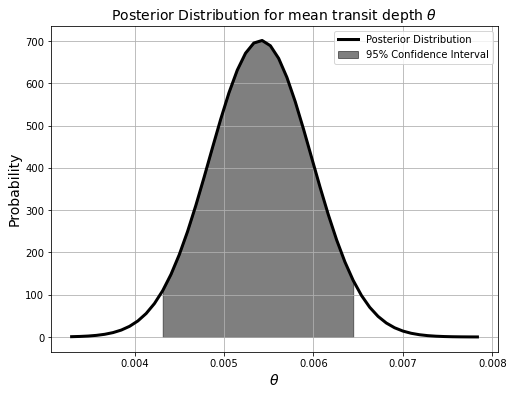

In [10]:
ab = (0, 1)
fig, ax = plot_posterior_prob(tdf, params=ab, save=False, verbose=True);
ax.set_title(r'Posterior Distribution for mean transit depth $\theta$', size=14);
plt.show()

#### 3.2 Sensitivity Analysis
<a id='sensitivity'></a>

Alex's Sensitivity Analysis:

Testing the effect of the assumptions made in the prior to the posterior distribution by varying the $a$ and $b$ values. 

The three priors chosen:
 1. $a=0, b=1$ (the original prior)
 2. $a=10, b=100$
 3. $a=0.001, b=0.01$

theta_post =  0.0054089936695469396
var_post =  3.2334162544038725e-07
Radius of TOI-564b =  0.77408646146158 Rjup
variance =  0.003040578260230945 Rjup


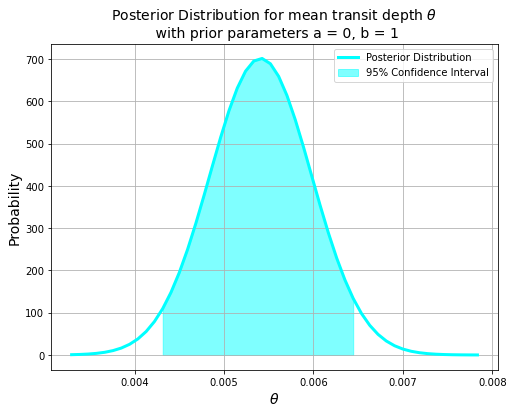


theta_post =  0.005408995401010771
var_post =  3.233417289447291e-07
Radius of TOI-564b =  0.7740865853573251 Rjup
variance =  0.0030405787035835087 Rjup


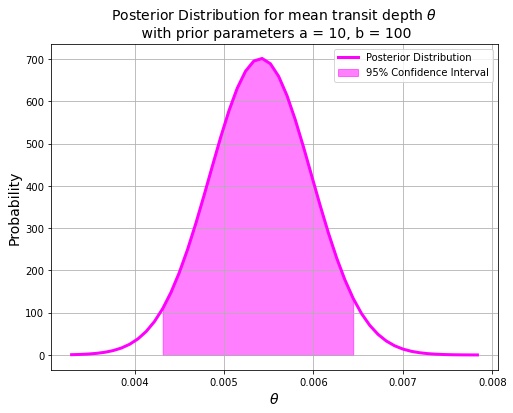


theta_post =  0.005408820528761612
var_post =  3.2333127534083493e-07
Radius of TOI-564b =  0.7740740721874754 Rjup
variance =  0.0030405339264078825 Rjup


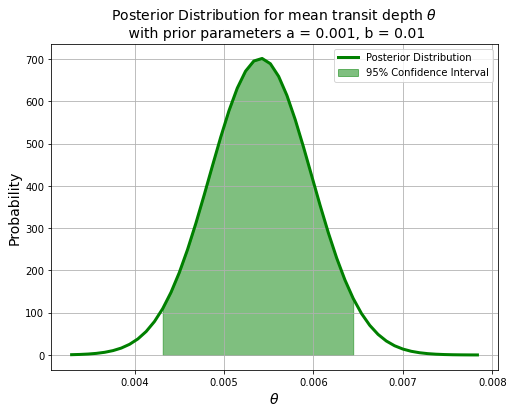


theta_post =  0.005407052834258557
var_post =  3.232256051831644e-07
Radius of TOI-564b =  0.7739475715676595 Rjup
variance =  0.0030400812967448297 Rjup


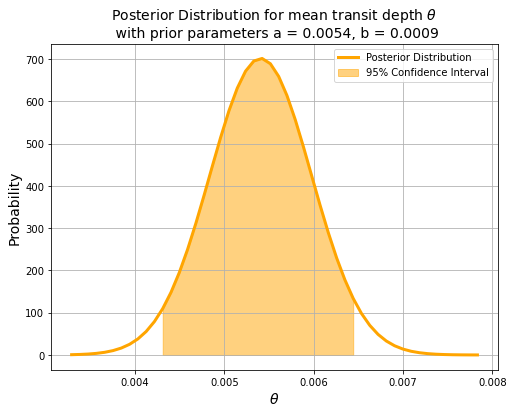

In [11]:
#setting the input values
v = (np.mean(df['NORM_FLUX_ERR'])**2)*2 #two points to get the transit depth so add error in quadrature to get the extra factor of 2 out front
n = len(tdf['Transit'])
xbar = np.mean(tdf['Depth'])

#posterior mean and variance array
params = [(0,1), 
(10,100),
(0.001,0.01),
(round(np.mean(tdf['Depth']),4),round(np.std(tdf['Depth']),4))
]


c = ['cyan', 
'magenta', 
'green',
'orange'
]

idx = 0
for ab in params:
    fig, ax = plot_posterior_prob(tdf, params=ab, c=c[idx], save=False);
    title = (r'Posterior Distribution for mean transit depth $\theta$' 
    '\n with prior parameters a = {}, b = {}'.format(ab[0], ab[1]));
    ax.set_title(title, size=14);
    plt.show()
    print()
    idx += 1

### 4. Results
<a id='results'></a>

*describe what we found and how we found it in markdown, then show plots and various things in python cells*

### 5. Discussion
<a id='discussion'></a>

*Maybe describe what we've learned? I'm not sure, this may be uneccessary*